In [1]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from scipy.integrate import odeint

sns.set()

# Dutch Book

Lets have a bookie (generator) and a gambler (discriminator).

The parameters of the bookie are the odds for each horse to win. 

the paramseters of the gambler are the amounts that they put on each value

In [2]:
"""
Generating the odds
"""

num_horses = 5

odds = np.exp(np.random.randn(num_horses))

probs = 1 / (1 + odds)

odds = tf.Variable(odds, dtype=tf.float32)

In [3]:
print(probs)

[0.72708166 0.21103272 0.58498378 0.28810403 0.21489869]


In [4]:
print(np.sum(probs))

2.0261008820719204


In [5]:
"""
Generating the wagers

We'll take the wagers to be tf.nn.softmax(zs), where zs 
is a tensor with 2*num_horses values

The first num_horses zs will correspond to wagers on losses. 
The final num_horses zs will give wagers for wins.
"""

zs = tf.Variable(np.random.randn(2 * num_horses), dtype=tf.float32)

The whole point of dutch book arguments is that they concern the possibility of always making money, regardless of what happens. This means the function of interest is the minimum reward. 

In [6]:
@tf.function
def minimum_winnings(
    wagers: tf.Tensor, odds: tf.Tensor, num_horses: int = num_horses
) -> float:
    """
    Returns the minimum possible winnings. If w_l and w_w is the wager for
    a horse losing and winning, then the return if we win is

    x*(w_w - w_l/x)

    if we lose we return

    w_l/x - w_w

    therefore define w' = w_w - w_l/x

    if win: x*w'
    if lose: -w'

    Only one horse can win, so collect all losses, -w', but one, x*w'.
    There are only 5 possible minimum values, since only one horse may win.
    Go through these and return the minimum possible winnings.

    Args:
        wagers (tf.Tensor): A length 2*num_horses tensor of wagers
        odds (tf.Tensor): A length num_horses tensor of odds
        num_horses (int, optional): The number of horses in the race

    Returns:
        float: [description]
    """
    assert len(wagers) == 2 * num_horses

    normalized_wagers = wagers[num_horses:] - wagers[:num_horses] / odds

    win_rewards = (
        odds * normalized_wagers + normalized_wagers - tf.reduce_sum(normalized_wagers)
    )

    # reward if the ith horse wins - losses when every other horse loses
    min_horse_index = tf.argmin(win_rewards)

    return win_rewards[min_horse_index]

In [7]:
def train_step(
    odds: tf.Tensor, zs: tf.Tensor, alpha: float, beta: float, num: int
) -> float:
    """
    The gambler wants to maximize the minimum reward, and the gambler
    wants to minimize this. This enacts a training iteration of the
    adversarial dynamic.

    Args:
        odds (tf.Tensor): The bookie's odds.
        zs (tf.Tensor): The logits of all wagers.
        alpha (float): The bookie's learning rate.
        beta (float): The gambler's learning rate.
        num (int): The number of discriminator updates per iteration.

    Returns:
        float: The minimum reward for the iteration.
    """
    for _ in range(num):
        with tf.GradientTape() as tape:
            wagers = tf.math.softmax(zs)
            min_reward = minimum_winnings(wagers, odds)

        gambler_gradients = tape.gradient(min_reward, zs)

        zs.assign(zs + beta * gambler_gradients)

    with tf.GradientTape() as tape:
        wagers = tf.math.softmax(zs)
        min_reward = minimum_winnings(wagers, odds)

    bookie_gradients = tape.gradient(min_reward, odds)

    odds.assign(odds - alpha * bookie_gradients)

    return min_reward.numpy()

In [8]:
reps = 10_000
rate1 = 0.1
rate2 = 0.1

all_wagers = []
all_odds = []
min_rewards = []

for rep in range(reps):
    min_rewards.append(train_step(odds, zs, rate1, rate2, 50))
    all_wagers.append(tf.math.softmax(zs).numpy())
    all_odds.append(odds.numpy())

all_wagers = np.array(all_wagers)
all_odds = np.array(all_odds)
min_rewards = np.array(min_rewards)

Let's check that our bookie has learned that probabilities add to 1.

In [9]:
all_probs = []

for current_odds in all_odds:
    all_probs.append(np.sum(1 / (1 + current_odds)))

In [10]:
print(all_probs[-1])


if abs(1 - all_probs[-1]) < 0.01:
    print("great work, man!")
else:
    print("get it together")

0.99524933
great work, man!


# Making Visualizations

In [11]:
Color = Union[Tuple[float, ...], str]

In [12]:
def smooth(
    xs: np.ndarray, ys: np.ndarray, interval: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Average out ys over a given interval of the indices.

    Args:
        xs (np.ndarray): The x values, assumed to be evenly spaced for averaging to make
            sense.
        ys (np.ndarray): The corresponding y values.
        interval (int): Interval over which we'll be averaging.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple of reduced xs (one value taken for each
            interval), and smooth ys.
    """

    new_xs = [xs[idx] for idx in range(0, len(xs), interval)[:-1]]
    new_ys = [
        np.mean(ys[idx : idx + interval]) for idx in range(0, len(xs), interval)[:-1]
    ]

    return new_xs, new_ys


def pos_and_neg_segments(
    xs: np.ndarray, ys: np.ndarray
) -> Tuple[List[Tuple[np.ndarray, np.ndarray]], List[Tuple[np.ndarray, np.ndarray]]]:
    """Make a list of continuous segments with positive y values, and continuous
    segments with negative y values. Produces two lists, one for positive segments,
    one for negative segments. Each list element is a tuple for the (positive or
    negative) segment of the form, (region x values, region y values).

    Args:
        xs (np.ndarray): x data.
        ys (np.ndarray): y values corresponding to xs.

    Returns:
        Tuple[List[Tuple[np.ndarray, np.ndarray]], List[Tuple[np.ndarray, np.ndarray]]]:
            A tuple of the positive regions, and the negative regions.
    """
    assert len(xs) == len(ys)
    assert len(xs) > 0

    pos_regions = []
    neg_regions = []

    idx1 = 0
    idx2 = 1
    temp_xs = [xs[0]]
    temp_ys = [ys[0]]

    while idx2 < len(xs):
        while idx2 < len(xs) and ((ys[idx1] > 0) == (ys[idx2] > 0)):
            temp_xs.append(xs[idx2])
            temp_ys.append(ys[idx2])
            idx2 += 1

        if ys[idx1] > 0:
            pos_regions.append((np.array(temp_xs), np.array(temp_ys)))
        else:
            neg_regions.append((np.array(temp_xs), np.array(temp_ys)))

        idx1 = idx2

        idx2 = idx1 + 1

        if idx1 < len(xs):
            temp_xs = [xs[idx1]]
            temp_ys = [ys[idx1]]

        if idx1 == len(xs) - 1:
            if ys[idx1] > 0:
                pos_regions.append((np.array(temp_xs), np.array(temp_ys)))
            else:
                neg_regions.append((np.array(temp_xs), np.array(temp_ys)))

    return pos_regions, neg_regions


def plot_with_sign(
    xs: np.ndarray,
    ys: np.ndarray,
    positive_color: Color,
    negative_color: Color,
    smooth_interval: int = 100,
    fig_ax: Optional[Tuple[matplotlib.figure.Figure, matplotlib.axis.Axis]] = None,
    fill: bool = True,
) -> Tuple[matplotlib.figure.Figure, matplotlib.axis.Axis]:
    """Plot xs and ys with different colors if ys are positive or negative.
    Also allows a shaded vertical fill for positive and negative regions.

    Args:
        xs (np.ndarray): a data.
        ys (np.ndarray): Corresponding y data.
        positive_color (Color): Color for the positive segments and
            (optionally) the vertical fill.
        negative_color (Color): Color for the negative segments and
            (optionally) the vertical fill.
        smooth_interval (int): Interval to average over. Defaults to 100.
        fig_ax (Optional[Tuple[matplotlib.figure.Figure, matplotlib.axis.Axis]], optional):
            Figure and axis to plot on. If None, these are created. Defaults to None.
        fill (bool): A bool for whether vertical shading should be used during plotting.
            Defaults to True.

    Returns:
        Tuple[matplotlib.figure.Figure, matplotlib.axis.Axis]: [description]
    """
    smoothed_xs, smoothed_ys = smooth(xs, ys, interval=smooth_interval)

    pos_regions, neg_regions = pos_and_neg_segments(smoothed_xs, smoothed_ys)

    if fig_ax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = fig_ax

    pos_label = False
    neg_label = False

    if fill:
        for pos_region in pos_regions:
            ax.axvspan(
                pos_region[0][0], pos_region[0][-1], alpha=0.2, color=positive_color
            )
        for neg_region in neg_regions:
            ax.axvspan(
                neg_region[0][0], neg_region[0][-1], alpha=0.2, color=negative_color
            )

    for region in pos_regions:
        cxs, cys = region

        if pos_label is False:
            ax.plot(cxs, cys, color=positive_color, label="Positive Winnings")
            pos_label = True

        else:
            ax.plot(cxs, cys, color=positive_color)

    for region in neg_regions:
        cxs, cys = region

        if neg_label is False:
            ax.plot(cxs, cys, color=negative_color, label="Negative Winnings")
            neg_label = True
        else:
            ax.plot(cxs, cys, color=negative_color)

    if pos_label and neg_label:
        ax.legend()

    return fig, ax

## Plot Minimum Winnings

In [13]:
time_cutoff = 8_000

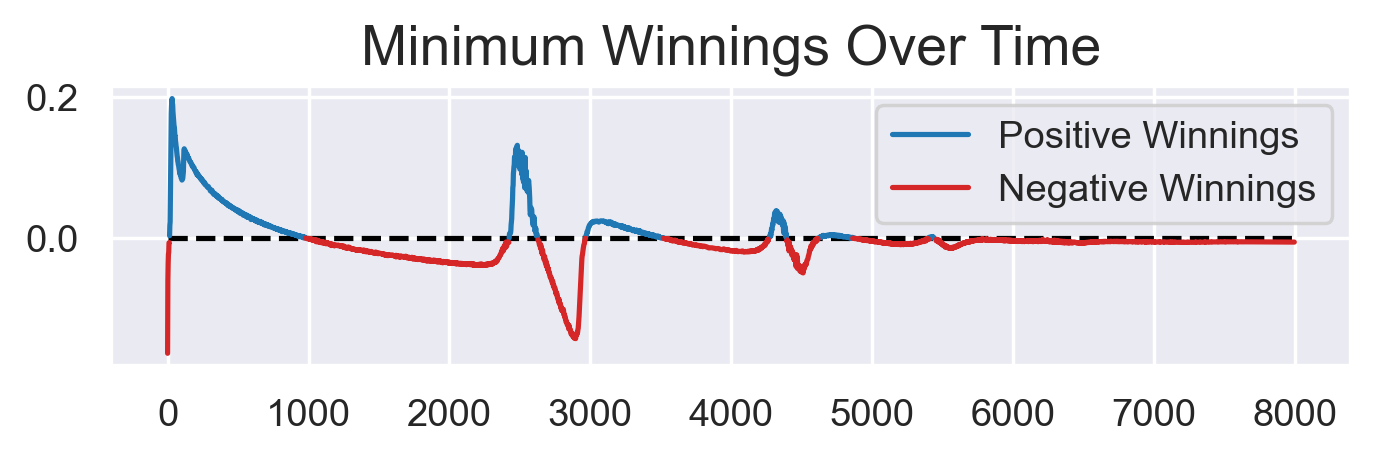

In [14]:
fig, ax = plot_with_sign(
    range(time_cutoff),
    min_rewards[:time_cutoff],
    positive_color=sns.color_palette("tab10")[0],
    negative_color=sns.color_palette("tab10")[3],
    smooth_interval=2,
    fig_ax=plt.subplots(dpi=250),
    fill=False,
)

ax.hlines(0, 0, time_cutoff, linestyle="dashed", color="black", zorder=1, alpha=1)
ax.set_title("Minimum Winnings Over Time", fontsize=16)

ax.set_aspect(5000)
plt.show()

## Plotting Bets

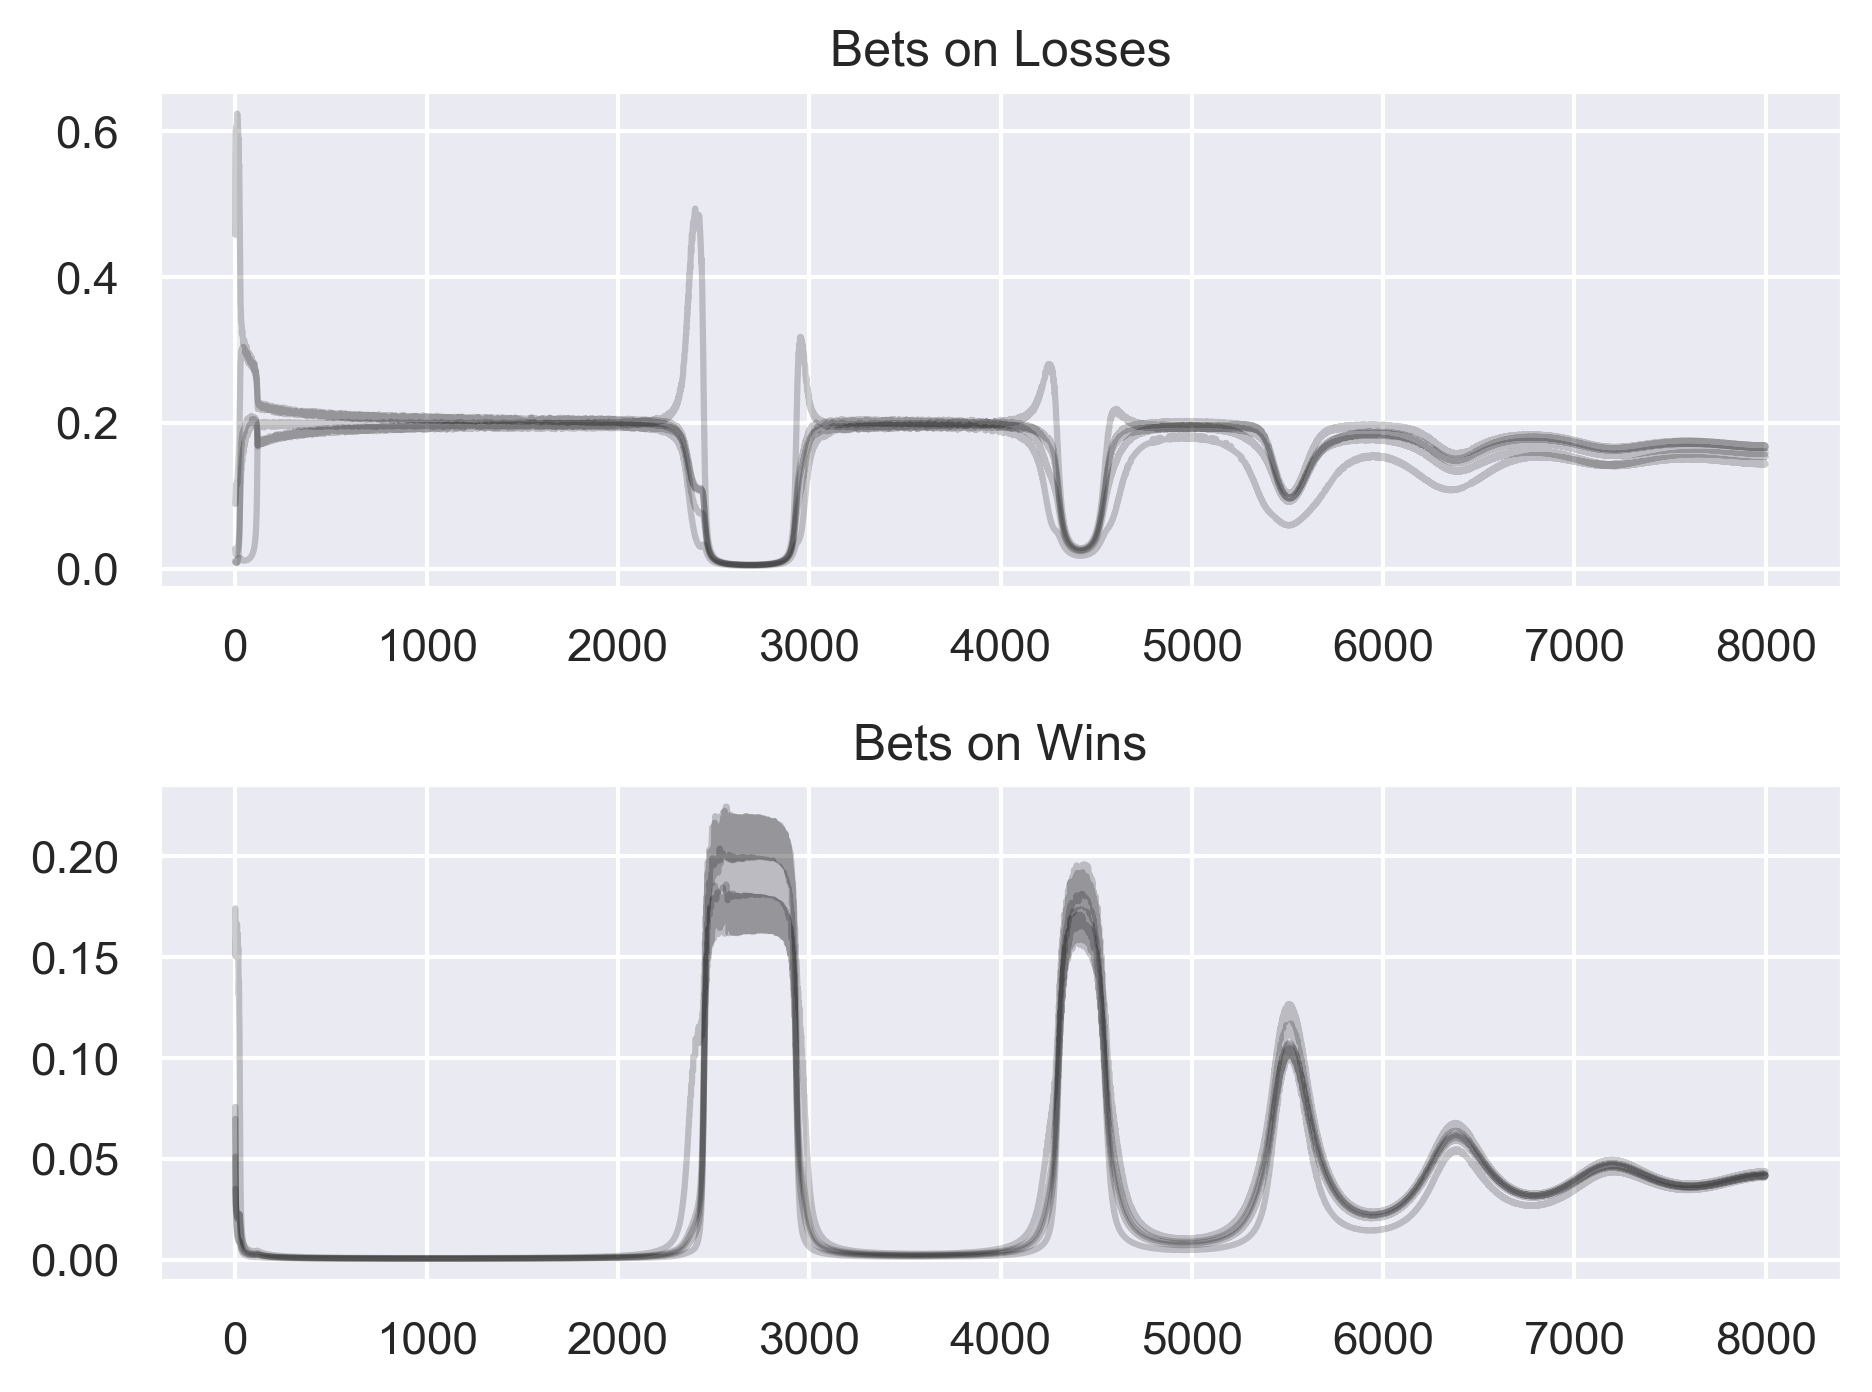

In [16]:
fig, ax = plt.subplots(2, dpi=300)

ax[0].set_title("Bets on Losses")
ax[1].set_title("Bets on Wins")

for i in range(5):
    ax[0].plot(all_wagers[:time_cutoff, i], c="black", alpha=1 / 5)
    ax[1].plot(all_wagers[:time_cutoff, 5 + i], c="black", alpha=1 / 5)

plt.tight_layout()
plt.show()

## Min. Winnings and Bets

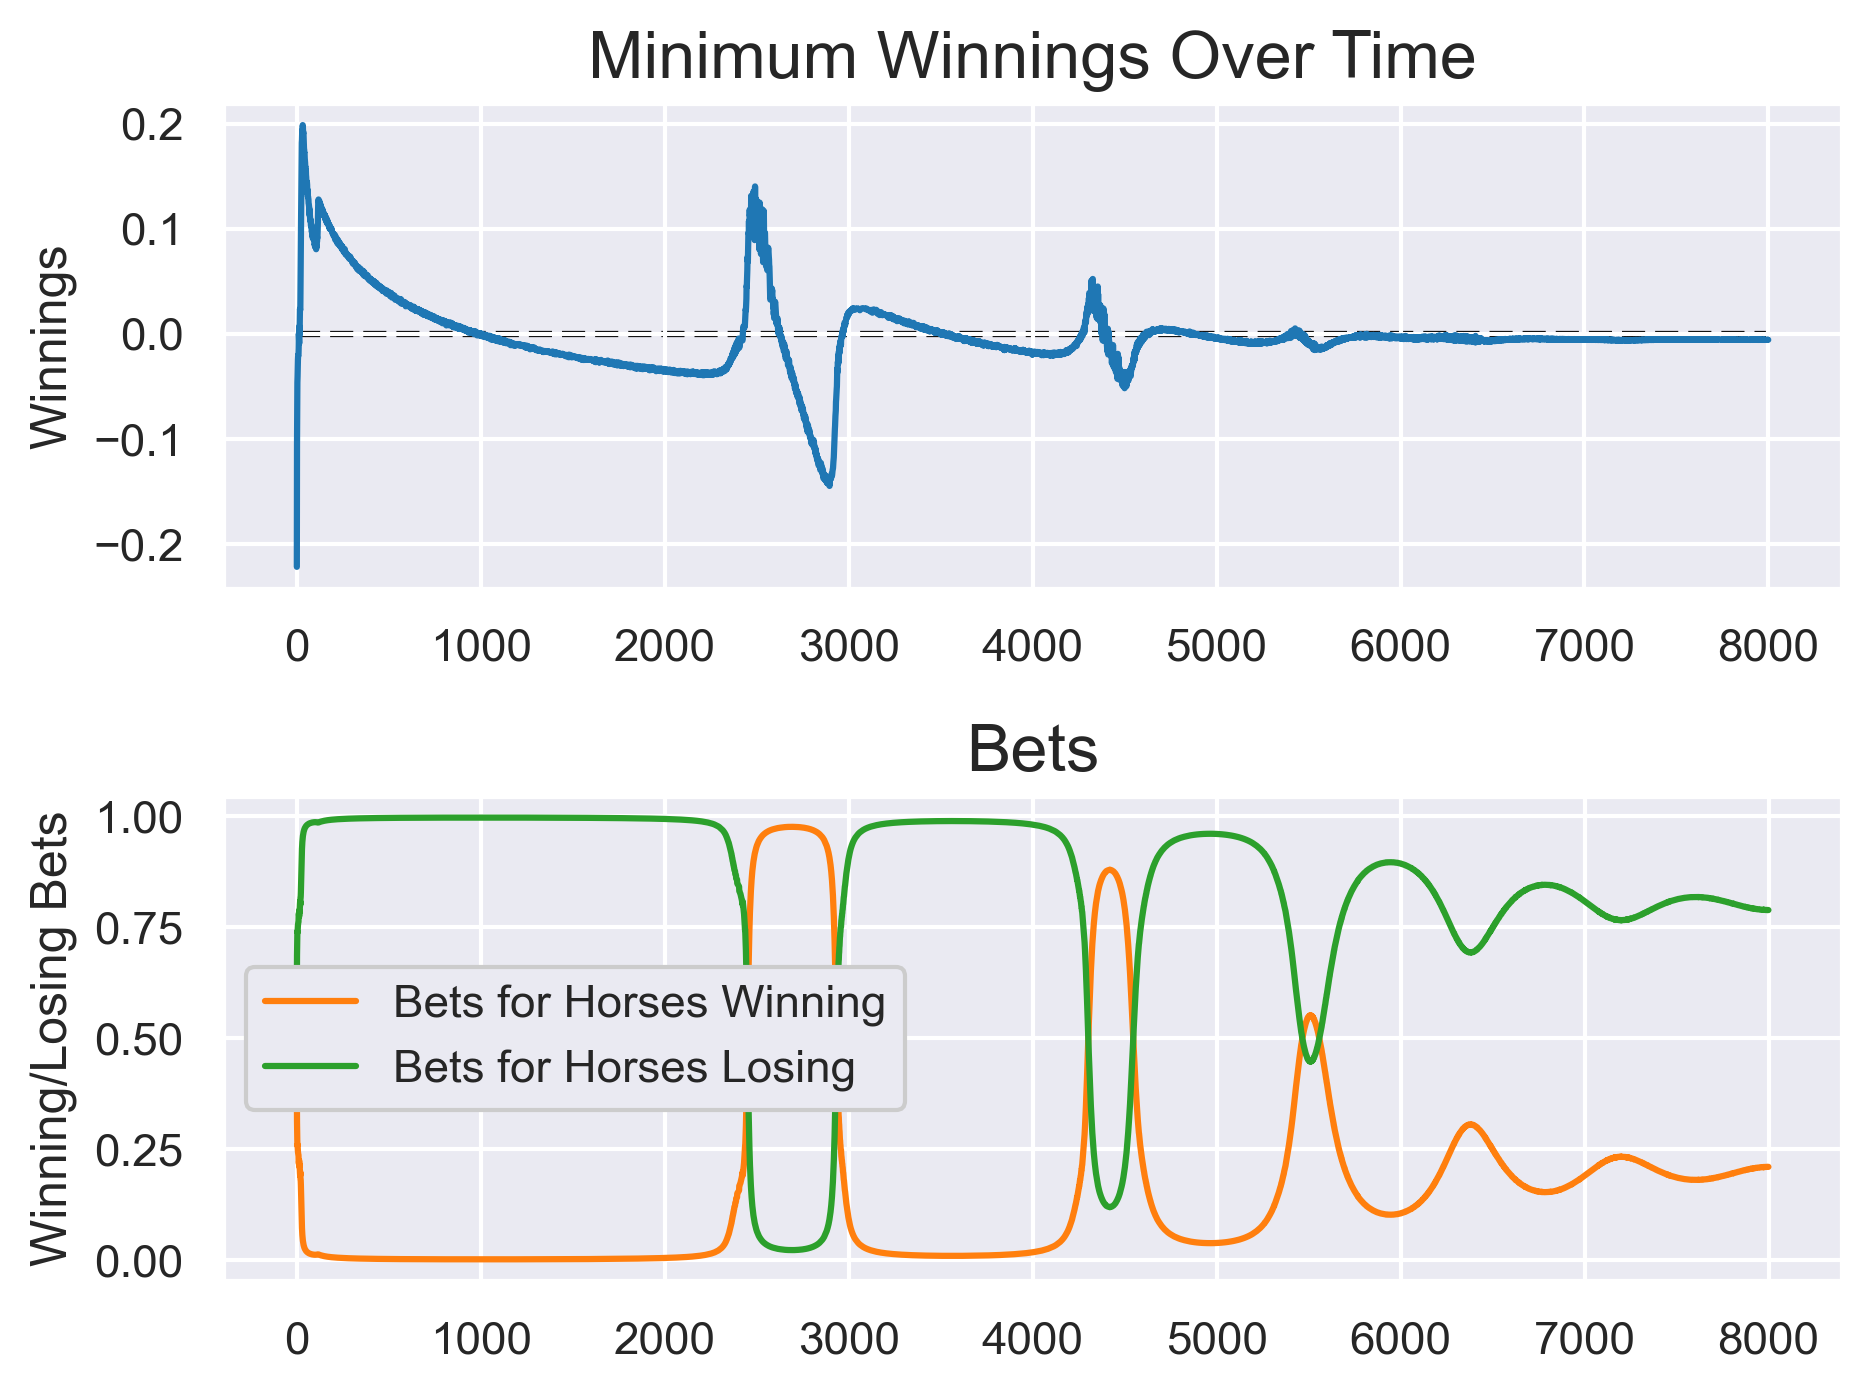

In [17]:
f, a = plt.subplots(2, dpi=300)

a[0].plot(min_rewards[:time_cutoff], color=sns.color_palette("tab10")[0])
a[0].hlines(0, 0, time_cutoff, linestyle="dashed", color="black", zorder=-1, alpha=1)
a[0].set_title("Minimum Winnings Over Time", fontsize=16)
a[0].set_ylabel("Winnings")


a[1].plot(
    np.sum(all_wagers[:time_cutoff, 5:], -1),
    label="Bets for Horses Winning",
    color=sns.color_palette("tab10")[1],
)
a[1].plot(
    np.sum(all_wagers[:time_cutoff, :5], -1),
    label="Bets for Horses Losing",
    color=sns.color_palette("tab10")[2],
)

a[1].set_title("Bets", fontsize=16)
a[1].set_ylabel("Winning/Losing Bets")

a[1].legend(framealpha=1)

plt.tight_layout()
plt.show()

## Plot Implicit Probs

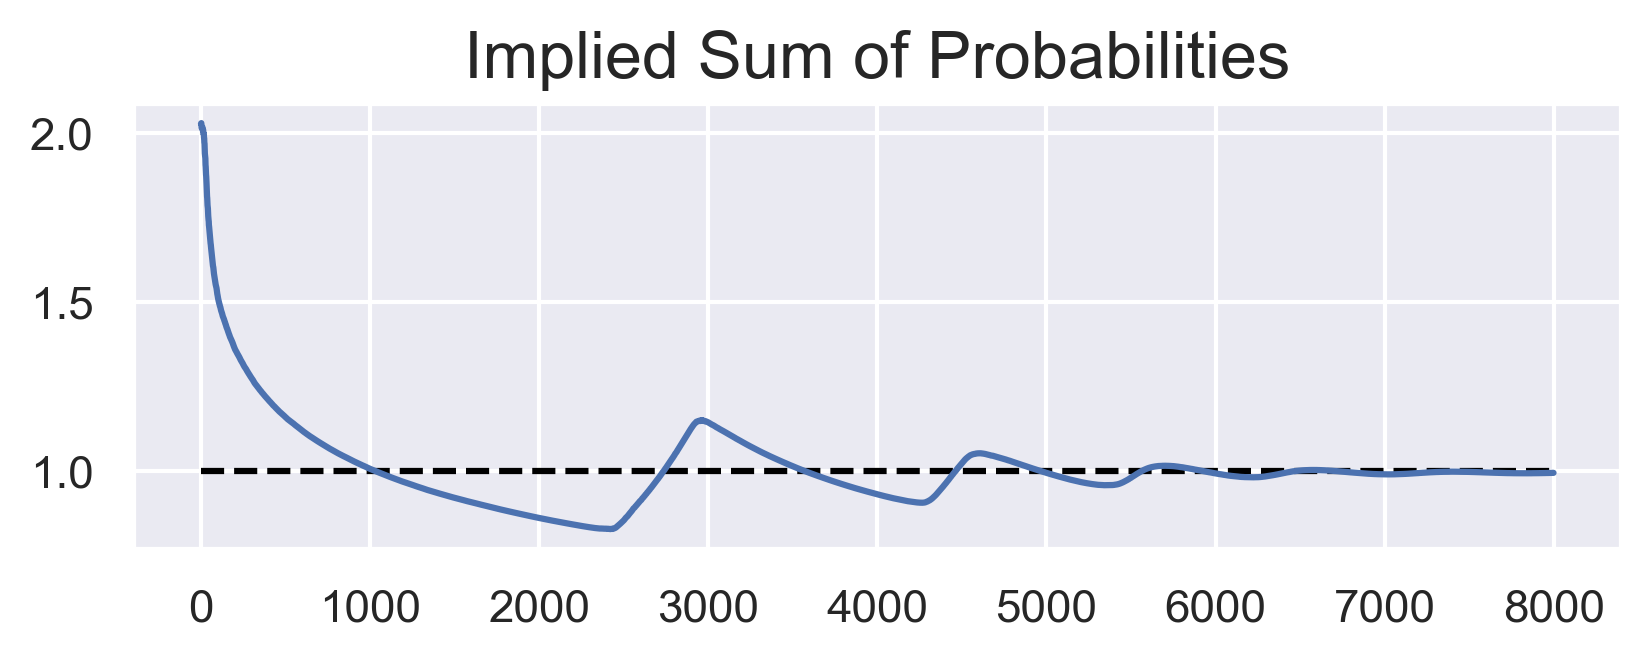

In [18]:
fig, ax = plt.subplots(dpi=300)

ax.hlines(1, 0, time_cutoff, linestyle="dashed", color="black", alpha=1)
ax.plot(all_probs[:time_cutoff])
ax.set_title("Implied Sum of Probabilities", fontsize=16)

ax.set_aspect(2000)
plt.show()

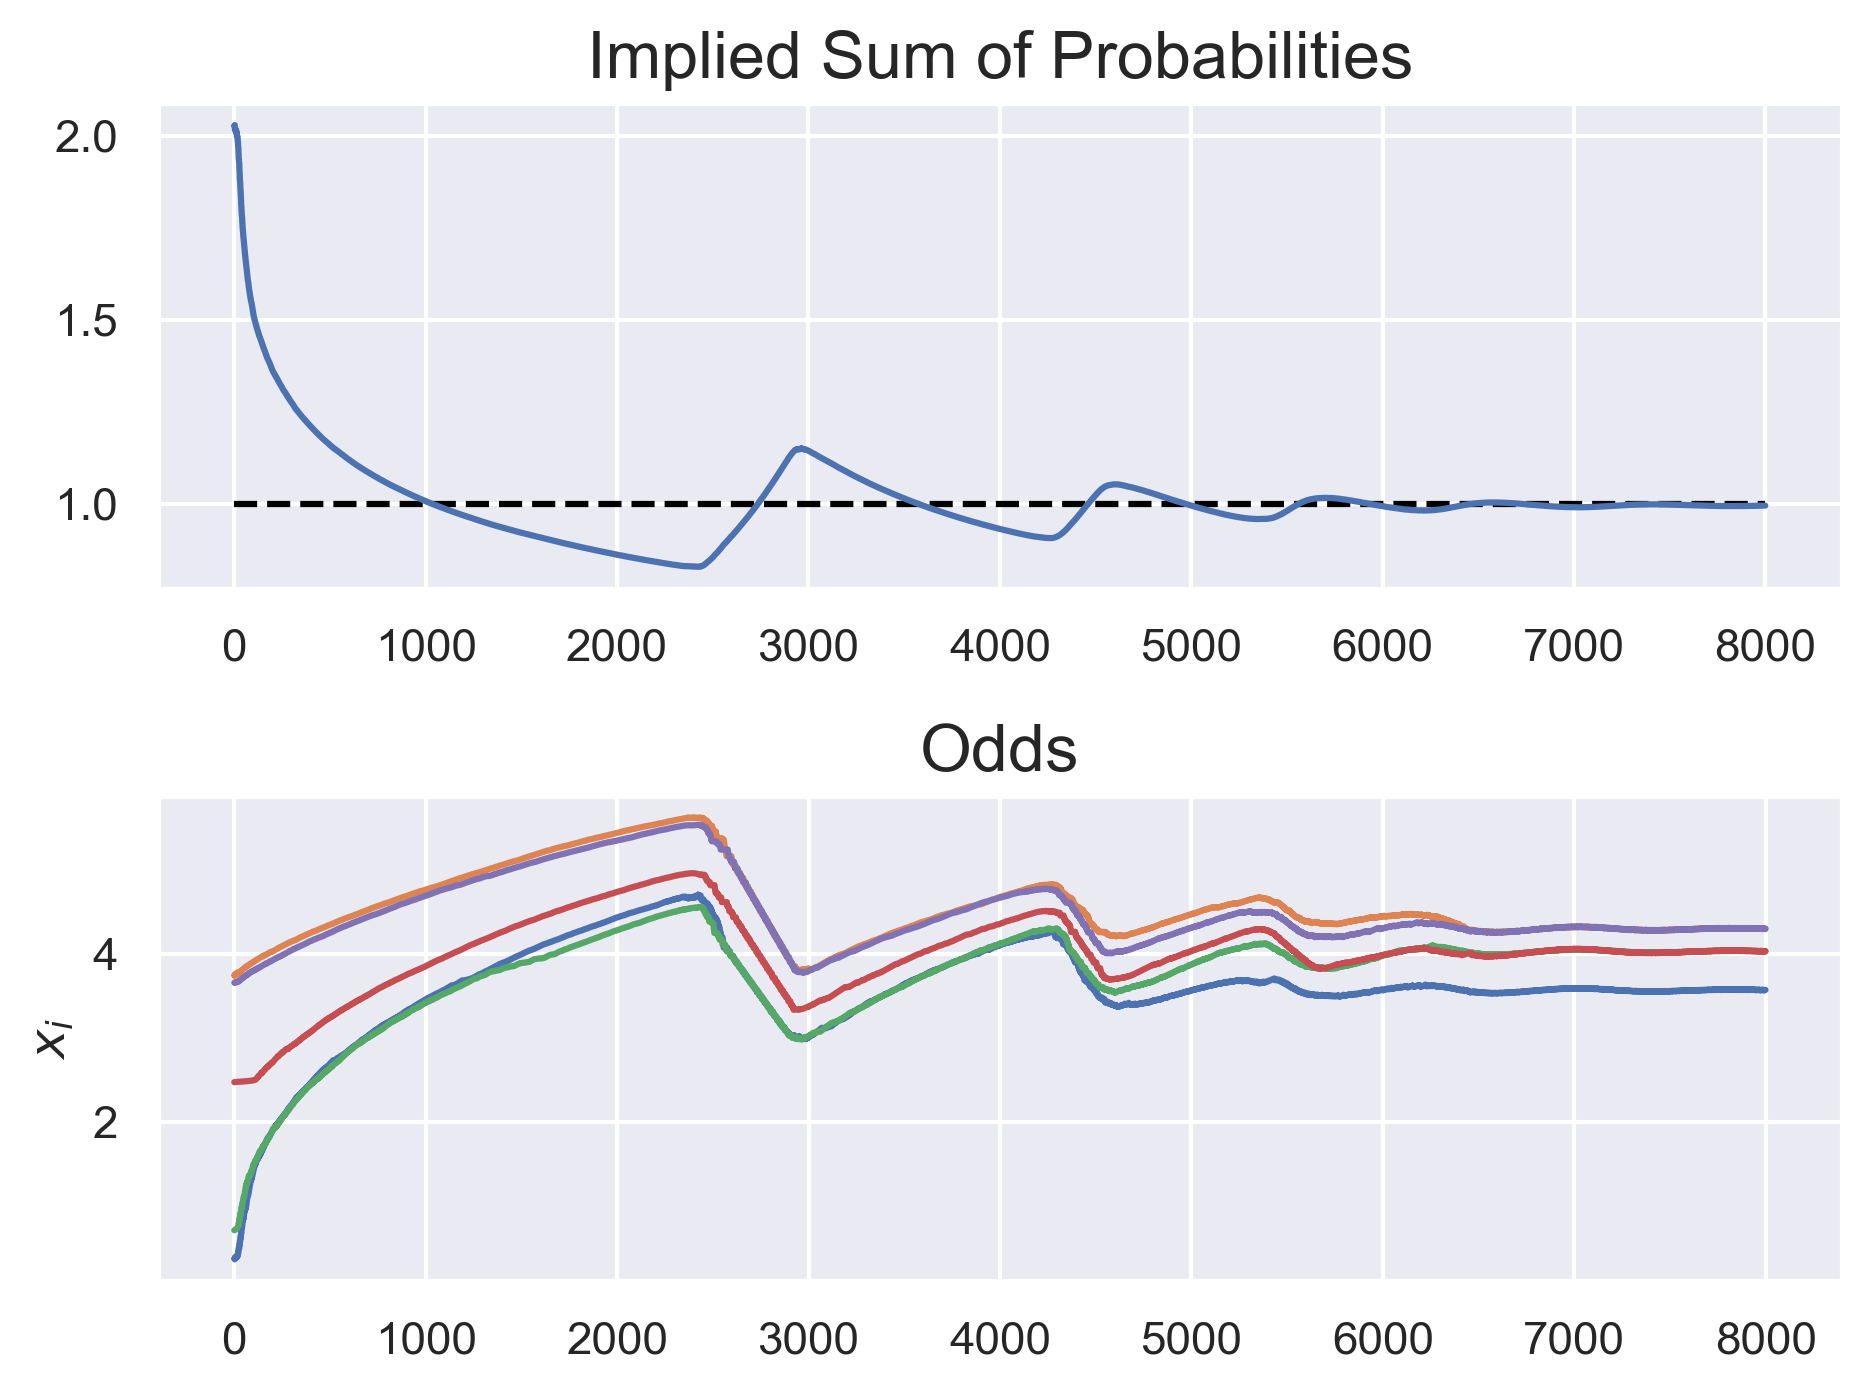

In [19]:
fig, ax = plt.subplots(2, dpi=300)

ax[0].hlines(1, 0, time_cutoff, linestyle="dashed", color="black", alpha=1)
ax[0].plot(all_probs[:time_cutoff])
ax[0].set_title("Implied Sum of Probabilities", fontsize=16)


ax[1].plot(all_odds[:time_cutoff, :])
ax[1].set_title("Odds", fontsize=16)
ax[1].set_ylabel(r"$x_i$")

plt.tight_layout()
plt.show()